# Merixstudio tweet sentiment analysis

## Initial notebook settings

We will start with importing necessary Python packages. There are quite a few, bear with me!

In [43]:
# General imports
import re
import numpy as np
from tqdm.notebook import tqdm
from typing import List

# Data preparation
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Vizualization
from matplotlib import pyplot as plt
from wordcloud import WordCloud

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from keras import utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

Now I have to access my Google Drive to access training data and GloVe. This step is necessary only, if you are running this notebook on Google Colab and have hosted both files on your Google Drive. If you run the code locally, you can skip this step and change `DATA_LOCATION` and `GLOVE_LOCATION` accordingly.

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will download the necessary English stopwords and the wordnet. If you tried coding some NLP problems before, you probably already have this on your machine.

In [45]:
# Download nltk resources
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Below we will add some constants to be used later in the code. Feel free to play around with the file locations or ML parameters.

In [46]:
# Data constants
DATA_LOCATION = "/content/drive/MyDrive/Colab Notebooks/data/merixstudio_tweet/training.1600000.processed.noemoticon.csv"
GLOVE_LOCATION = "/content/drive/MyDrive/Colab Notebooks/data/merixstudio_tweet/glove.6B.100d.txt"
STOP_WORDS = set(stopwords.words("english"))
STEMMER = PorterStemmer()
LEMMATIZER = WordNetLemmatizer()

In [47]:
#Machine Learning Constants
RANDOM_STATE = 42
NUMBER_OF_EPOCHS = 10
BATCH_SIZE = 1000
LEARNING_RATE = 0.001

## Preparing data for Machine Learning

The sentiment analysis dataset was downloaded from Kaggle and is available here:
- [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/kazanova/sentiment140)

We will load this dataset. As you can see, we need to set a few things:
- `encoding` will be set to `ISO-8859-1`, otherwise we will get corrupted data,
- `header` is set to `None`, because the dataset doesn't have a row that represents column names,
- `names` is how we will name the columns.

In [48]:
# Load the twitter sentiment dataset
tweets = pd.read_csv(
    DATA_LOCATION,
    encoding="ISO-8859-1",
    header=None,
    names=(
        "target",
        "tweet_id",
        "date",
        "flag",
        "user",
        "text",
    ),
)
tweets.sample(10)

,target,tweet_id,date,flag,user,text
698929,0,2254287971,Sat Jun 20 09:31:01 PDT 2009,NO_QUERY,mrgrafix,"Yes, Im going back to Cali for two weeks! But ..."
734579,0,2264583678,Sun Jun 21 04:19:50 PDT 2009,NO_QUERY,OoAlexandraoO,http://twitpic.com/7zxi2 - now I am in la and ...
721007,0,2261060279,Sat Jun 20 20:12:02 PDT 2009,NO_QUERY,lynneeezy,&quot;i'd stay like this forever if i could..&...
133829,0,1836098681,Mon May 18 07:22:03 PDT 2009,NO_QUERY,Ella_bella_,@katepatto it really hurt! i hope the parenta...
1125538,4,1974869303,Sat May 30 13:59:18 PDT 2009,NO_QUERY,emma42a,well pleased looking at the tweets made up
388210,0,2054182038,Sat Jun 06 06:45:44 PDT 2009,NO_QUERY,zoesalbahe,@exieabola one more here! Andy Pettite is amaz...
21534,0,1557302262,Sun Apr 19 03:15:29 PDT 2009,NO_QUERY,Shaunna27,Is excited to see the fam after work!!! Can't ...
1465684,4,2064384605,Sun Jun 07 06:06:58 PDT 2009,NO_QUERY,monarafs,"@billyraycyrus OMG, you like Brazil, this is r..."
598196,0,2219457247,Thu Jun 18 00:34:51 PDT 2009,NO_QUERY,prmack,anyone know any good screen capture programs f...
38237,0,1573212611,Tue Apr 21 00:10:28 PDT 2009,NO_QUERY,hackmancoltaire,@BrentSpiner please don't die! You'll take a p...


It is interesting to see that the authors of the dataset describe `3` values for the `target` of a tweet:
- `0` - negative, 
- `2` - neutral,
- `4` - positive.

If we check the actual counts of the dataset, we only have the following:

In [49]:
tweets.target.value_counts()

4    800000
0    800000
Name: target, dtype: int64

Oh well 🤷🏻‍♂️. We will clean up the a bit and prepare it for machine learning.

In [50]:
# Remove unused columns
tweets = tweets[["target", "text"]]

In [51]:
# Map target values to 0 and 1
tweets.target.replace({4: 1}, inplace=True)

We will build a simple text cleaning function. For production ready we would need to clean them much more, but for us this will be enough 😊.

In [52]:
# This will also be useful later
def clean_tweet_text(text: str) -> str:
    # Clean mentions, punctuation, etc.
    tokens = re.sub(
        (
            "(&[A-Za-z]+;)|"
            "(@[A-Za-z0-9_]+)|"
            "([^0-9A-Za-z \t])|"
            "(\w+:\/\/\S+)|"
            "(\d+)"
        ),
        " ",
        text.lower(),
    ).split()

    # Remove english stop words
    tokens = [token for token in tokens if token not in STOP_WORDS]

    # Stem words (change to root form)
    tokens = [STEMMER.stem(token) for token in tokens]

    # Lemmatize words (get actual word for the language)
    tokens = [LEMMATIZER.lemmatize(token) for token in tokens]

    return " ".join(tokens)


clean_text = []
for text in tqdm(tweets.text, desc="Processing rows"):
    text = clean_tweet_text(text)
    clean_text.append(text)
tweets["clean_text"] = clean_text

tweets.sample(10)

,target,text,clean_text
1450023,1,@Ktuluorian Balls ? So What New Tricks do you ...,ball new trick bring twitter check qc
429937,0,@Jamie_Spears Your sis was AMAZING last night!...,si amaz last night want go
925994,1,@TheUgh but i stopped trying a few minutes ago...,stop tri minut ago call friend gonna help
834310,1,Friend from 'diff just gone back. Friend from ...,friend diff gone back friend north wale due mi...
918465,1,"@alexa_chung oh get well soon Alexa, take some...",oh get well soon alexa take rest
1217854,1,Woken up in a very warm bed &amp; environment ...,woken warm bed environ hot least mean hot outs...
1031173,1,@triplejdools Def go to the pub,def go pub
622712,0,@mysize_barbie talkin all that stuff about no ...,talkin stuff ga n u got paid today smh u wanna...
711379,0,@SteveHarvin i havent seen u on here...and i t...,havent seen u think ima get fire
1366909,1,Follow friday If you follow me I'll follow you...,follow friday follow follow back like dyslex c...


Before we jump down into machine learning, let's see how the word cloud looks like for positive and negative sets!

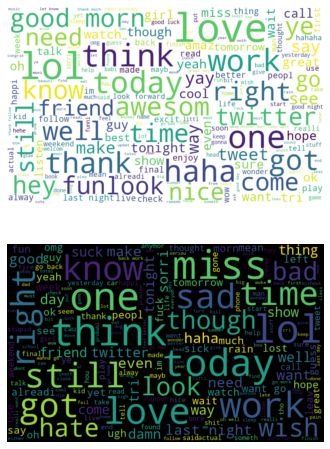

In [71]:
# Join all the words!
all_positive_words = " ".join([text for text in tweets[tweets.target == 1].clean_text])
all_negative_words = " ".join([text for text in tweets[tweets.target == 0].clean_text])

# Create a word cloud
positive_wordcloud = WordCloud(
    width=800,
    height=500,
    random_state=RANDOM_STATE,
    max_font_size=100,
    background_color="white",
).generate(all_positive_words)

negative_wordcloud = WordCloud(
    width=800,
    height=500,
    random_state=RANDOM_STATE,
    max_font_size=100,
).generate(all_negative_words)

# And display it!
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
axes[0].imshow(positive_wordcloud, interpolation="bilinear")
axes[0].axis("off")
axes[1].imshow(negative_wordcloud, interpolation="bilinear")
axes[1].axis("off")
plt.show()

I find it funny that so many negative tweets have the word `work` in them 😂. Also `love` is quite common in both sets 🤔.

## Machine Learning

In [54]:
# Split data for training and testing
train, test = train_test_split(tweets[["clean_text", "target"]], test_size=0.1, random_state=RANDOM_STATE)

print(f"Shape of the train dataset: {train.shape}.")
print(f"Shape of the test dataset: {test.shape}.")

Shape of the train dataset: (1440000, 2).
Shape of the test dataset: (160000, 2).


In [55]:
# Add padding to shorted tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.clean_text)
vocabulary_size = len(tokenizer.word_index) + 1
max_length = 50  # The max number of tokens for a tweet, seems fitting since Twitter restricts number of chars

sequences_train = tokenizer.texts_to_sequences(train.clean_text)
sequences_test = tokenizer.texts_to_sequences(test.clean_text)

X_train = pad_sequences(sequences_train, maxlen=max_length, padding="post")
X_test = pad_sequences(sequences_test, maxlen=max_length, padding="post")
y_train = train.target.values
y_test = test.target.values

In [56]:
embed_dict = dict()
embed_dimensions = 100

with open(GLOVE_LOCATION) as glove_file:
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype="float32")
        embed_dict[word] = vector_dimensions

embed_matrix = np.zeros((vocabulary_size, embed_dimensions))
for word, index in tokenizer.word_index.items():
    embedding_vector = embed_dict.get(word)
    if embedding_vector is not None:
        embed_matrix[index] = embedding_vector

In [57]:
# Defining the embedding layer
embed_layer = tf.keras.layers.Embedding(
    input_dim=vocabulary_size,
    output_dim=embed_dimensions,
    input_length=max_length,
    weights=[embed_matrix],
    trainable=False,
)

# Defining the model
model = Sequential(
    [
        embed_layer,
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.4),
        Bidirectional(LSTM(128)),
        Dropout(0.4),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)

In [58]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [59]:
# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=["accuracy"],
)

# Fit model on test data
def fit_model(model):
    return model.fit(
      X_train,
      y_train,
      batch_size=BATCH_SIZE,
      epochs=NUMBER_OF_EPOCHS,
      validation_data=(X_test, y_test),
      verbose=2,
  )

history = fit_model(model)

Epoch 1/10
1440/1440 - 311s - loss: 0.5342 - accuracy: 0.7273 - val_loss: 0.5092 - val_accuracy: 0.7447
Epoch 2/10
1440/1440 - 304s - loss: 0.5061 - accuracy: 0.7485 - val_loss: 0.4995 - val_accuracy: 0.7519
Epoch 3/10
1440/1440 - 303s - loss: 0.4940 - accuracy: 0.7565 - val_loss: 0.4942 - val_accuracy: 0.7556
Epoch 4/10
1440/1440 - 303s - loss: 0.4859 - accuracy: 0.7619 - val_loss: 0.4913 - val_accuracy: 0.7588
Epoch 5/10
1440/1440 - 303s - loss: 0.4796 - accuracy: 0.7659 - val_loss: 0.4831 - val_accuracy: 0.7634
Epoch 6/10
1440/1440 - 303s - loss: 0.4738 - accuracy: 0.7694 - val_loss: 0.4810 - val_accuracy: 0.7645
Epoch 7/10
1440/1440 - 303s - loss: 0.4686 - accuracy: 0.7728 - val_loss: 0.4791 - val_accuracy: 0.7666
Epoch 8/10
1440/1440 - 303s - loss: 0.4634 - accuracy: 0.7762 - val_loss: 0.4800 - val_accuracy: 0.7660
Epoch 9/10
1440/1440 - 303s - loss: 0.4584 - accuracy: 0.7793 - val_loss: 0.4778 - val_accuracy: 0.7669
Epoch 10/10
1440/1440 - 303s - loss: 0.4536 - accuracy: 0.7823 -

In [60]:
# Calculate y predictions based on the model
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

In [61]:
# Print the classification report for test/prediction
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76     79812
           1       0.75      0.80      0.77     80188

    accuracy                           0.77    160000
   macro avg       0.77      0.77      0.77    160000
weighted avg       0.77      0.77      0.77    160000



In [67]:
# Create a vectorizer object
vectorizer = CountVectorizer()

# Add and clean last Merixstudio English tweet
last_mrx_tweet = "Wondering how to wow investors with your pitch deck? Check out what Marko Kyyrönen from @Sparkmind_VC has to say about that http://bit.ly/3la3HT9"
clean_tweet = clean_tweet_text(last_mrx_tweet)
tweet_eval = [clean_tweet]

# Fit and predict
tweet_eval_numeric = vectorizer.fit_transform(tweet_eval).toarray()
prediction = model.predict(tweet_eval_numeric)

# Display the outcome
print(f"Original tweet: {last_mrx_tweet}")
print(f"Cleaned tweet: {clean_tweet}")
print(f"Outcome: {'Positive' if prediction[0] > 0.5 else 'Negative'}")

Original tweet: Wondering how to wow investors with your pitch deck? Check out what Marko Kyyrönen from @Sparkmind_VC has to say about that http://bit.ly/3la3HT9
Cleaned tweet: wonder wow investor pitch deck check marko kyyr nen say
Outcome: Positive


## Gathering Merixstudio tweets

## Sentiment analysis of Merixstudio tweets